# Chapter 10. 베이지안 머신러닝: 동적 샤프 비율과 페어 트레이딩

요약: 알고리듬 트레이딩 전략을 개발하고 평가할 때 불확실성에 대응하는 방법 소개
</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;→ 금융 시장은 본질적으로 불확실하고, 이를 효과적으로 다루기 위해 다양한 기법과 전략이 필요

- 베이지안 통계가 머신러닝에 적용되는 방법
- PyMC3로 확률적 프로그래밍
- PyMC3로 머신러닝 모델을 정의하고 훈련시키는 법
- 근사 추론을 위한 최신 표본 추출 방법
- 동적 샤프 비율 계산 및 동적 페어 트레이딩 해지 비율, 확률 변동성을 추정하고자 베이지안 머신러닝을 적용하는 방법

## 10.1 베이지안 머신러닝 학습법

빈도주의(고전적인 통계 기법) VS 베이지안 통계
- 빈도주의: 확률을 사건의 빈도로 보는 것</br>
여러 번 발생한 사건들을 관측하고 취합하여 그 확률을 검정하므로, 각각의 사건이 독립성을 띈다는 것을 암시하고, 모수(parameter)를 불변의 값으로 취급</br>
＊모수(parameter, 우리가 알아내고자 하는 값, 평균, 분산등)는 (우리가 모르는) 고정 된 상수</br>
확률을 계산하기에 표본이 부족한 경우에는 확률의 신뢰도가 떨어질 수 있고, 극단적으로는 반복이 불가능한, 지금까지 일어나지 않았던 사건에 한에서는 확률 계산 자체가 불가능
- 베이지안: 확률을 사건 발생에 대한 믿음 또는 척도로 바라보는 관점</br>
모수를 불변의 값이라고 생각할 필요가 없고, 정황상 변할 수 있는 가변의 값이 될 수 있음을 암시</br>
100년 안에 지구가 멸망할 확률을 알고 싶을 때, 빈도주의적 관점에서는 계산이 불가능하지만 베이지안 관점에서 봤을 때, 이미 우리가 알고 있는 정황증거와 정보들을 통해 귀납적 추론으로 계산을 할 수 있고, 심지어 수집하는 정보에 따라 해당 확률을 '업데이트'할 수 있음</br>
＊다음 선거 결과, 3개월 이내 시장이 폭락할 것인가?</br>
사전 지식에 대한 모델링이 어렵고 사전 지식 모델링에 따른 사후 확률 결과가 크게 달라질 수 있음

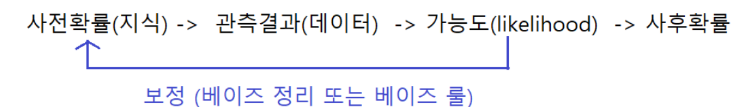

*예시</br>
1. 동전을 던졌을 때 앞/뒷면이 나오는 사건의 확률
- 빈도주의 - 동전을 던져 앞면이 나오는 사건의 '확률'은 0.5이다.
- 베이지안 - '앞면이 나왔다'는 주장의 신뢰도가 0.5이다.
2. 검진결과에 의해 암에 걸렸을 확률이 90%이다.
- 빈도주의(의사관점) - 이러한 검진결과를 가진환자는 정밀검사를 하면 100에 90명은 암에 걸려있다.
- 베이지안(환자관점) - 자신이 암에 걸렸음을 주장하는 의사의 주장이 사실일 가능성(신뢰도)가 90%이다.

① 사전 확률의 가정을 경험적 증거와 결합하여 믿음을 업데이트하는 베이즈 정리 소개</br>
② 결과 파라미터 추정치를 빈도주의 대응치와 비교</br>
③ 베이지안 통계 추론 접근 방식 소개(켤레 사전 분포, 근사 추론)

### 10.1.1 경험적 증거에서 가정을 업데이트하는 방법

"사실 관계가 바뀌면 나는 생각을 바꿉니다." - 존 메이너드  케인즈

베이즈 정리</br>
토마스 베이즈가 새로운 정보에 따라 확률이나 신념이 어떻게 변해야하는지를 규정하고자 근본적인 확률 이론 제시 → 조건부 확률, 총확률, 체인룰에 의존

기본 개념 정리
- 베이지안 확률: 믿음의 정도(어떤 사건이 발생할 가능성에 대해 얼마나 확신하는지...)</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;사전 확률, 우도, 사후 확률 모두 포함.</br>
- 파라미터: 모집단의 특성을 나타내는 값, 데이터를 통해 파라미터의 값을 추론</br>
- 사전확률: 사전 지식이나 가정을 반영</br>
-- 사전확률 (Prior Probability): 질병에 걸릴 확률이 1%라고 가정했을 때, 이 1%가 사전확률</br>
-- 파라미터: 해당 질병의 발병률(예: 1%)이나 검사의 민감도(예: 99%) 등은 모델을 설명하는 파라미터가 될 수 있습니다.</br>

- 우도함수(Likelihood): 주어진 파라미터 값에서 데이터가 관찰될 확률</br>
- 증거(evidence): 관찰된 데이터가 가설이 타당한지 나타냄
- 베이지안 추론: 베이지안 확률을 사용하여 데이터를 기반으로 모델의 파라미터나 사건의 확률을 추정하는 방법론, 사전확률(데이터 관찰 전 파라미터에 대한 믿음)과 우도, 데이터를 결합하여 사후확률(데이터 관찰 후 파라미터에 대한 믿음)을 계산</br>

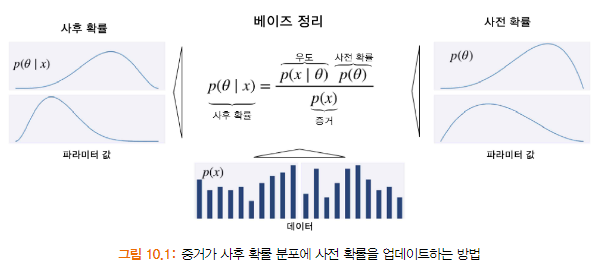

#### 베이지안 추론 예시: 암 진단

### 문제:
새로운 암 검사법의 정확성을 평가하고 싶습니다. 이 검사법은 암에 걸린 사람의 95%를 정확하게 진단하지만, 암에 걸리지 않은 사람의 5%를 오진합니다.

### 목표:
특정 환자가 이 검사에서 양성 반응을 보였을 때, 실제로 암에 걸렸을 확률은 얼마일까요?

### 베이즈 정리 적용:

- **사전 확률**: 암 발병률은 인구의 1%라고 가정합니다. 즉, 임의의 사람이 암에 걸릴 확률은 0.01입니다.
- **데이터**: 특정 환자가 검사에서 양성 반응을 보였습니다.

#### 사후 확률 계산:

- A: 환자가 암에 걸렸다는 사건
- B: 검사 결과 양성이라는 사건

베이즈 정리에 따르면:
\[ P(A|B) = \frac{P(B|A) \times P(A)}{P(B)} \]

- \( P(A|B) \): 양성 반응을 보인 환자가 실제로 암에 걸렸을 확률 (우리가 찾고자 하는 값)
- \( P(B|A) \): 암에 걸린 환자가 양성 반응을 보일 확률 (검사의 민감도, 0.95)
- \( P(A) \): 암 발병률 (사전 확률, 0.01)
- \( P(B) \): 검사 결과 양성이 나올 확률 (전체 확률, \( P(B) = P(B|A) \times P(A) + P(B|not A) \times P(not A) \))
- \( P(B|not A) \): 암에 걸리지 않은 환자가 양성 반응을 보일 확률 (검사의 오진율, 0.05)
- \( P(not A) \): 암에 걸리지 않을 확률 (1 - 암 발병률, 0.99)

따라서 \( P(B) = 0.95 \times 0.01 + 0.05 \times 0.99 = 0.059 \)

이제 베이즈 정리에 값을 대입하면:
\[ P(A|B) = \frac{0.95 \times 0.01}{0.059} \approx 0.161 \] (약 16.1%)

### 결론:
양성 반응을 보인 환자가 실제로 암에 걸렸을 확률은 약 16.1%입니다. 즉, 검사 결과가 양성이라고 해도, 실제로 암에 걸렸을 가능성은 낮습니다. 이는 검사의 오진율이 높기 때문입니다.

*교재에서...</br>
빈도주의와 베이지안 주요 차이점</br>
빈도주의에서 가정은 하나의 값이지만 베이지안의 가정은 확률의 분포로**도** 표현된다...</br>
데이터가 관찰되면 바뀔 수 있기 때문에...

### 10.1.2 정확한 추론: 최대 사후 확률 추정

증거와 주변 우도를 계산하는 어려움 때문에 베이즈 규칙을 정확히 적용하는 것은 제한적임</br>
*파라미터 다차원, 복잡한 우도함수...

**파라미터 선택하는 방법을 설명**

최대 사후 확률(MAP) 추정 - 베이지안적 접근 방식</br>
사후 확률을 최대화하는 파라미터 찾음</br>
정의: 증거가 주어졌을 때 사후 분포에서 가장 높은 확률을 가지는 값을 선택하는 방법</br>
핵심: 사후 확률은 사전 확률과 우도 함수의 곱으로 정의. 즉, 주어진 데이터와 가설에 대해 가장 가능성이 높은 파라미터 값을 찾는 것

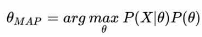

최대 우도 추정(MLE) - 빈도주의적 접근 방법</br>
우도함수를 최대화하는 파라미터 찾</br>
정의: 데이터에 대해 가장 가능성이 높은 파라미터 값을 찾는 방법</br>
핵심: MLE는 사전 확률을 고려하지 않고, 단지 주어진 데이터에서 우도를 최대화하는 파라미터 값을 선택

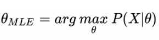

두 방법의 차이</br>
사전 확률: MAP 추정은 사전 확률을 고려하지만, MLE는 고려하지 않음</br>
</br></br>
MLE와 MAP의 장단점</br>
MLE:</br>
장점: 계산이 단순하고, 사전 확률에 대한 정보를 필요로 하지 않습니다.</br>
단점: 사전 확률을 고려하지 않기 때문에, 데이터가 적거나 불확실할 때는 정확도가 떨어질 수 있습니다.</br></br>
MAP:</br>
장점: 사전 확률을 고려하기 때문에, 데이터가 적거나 불확실할 때 더 좋은 성능을 보일 수 있습니다.</br>
단점: 사전 확률을 어떻게 설정하느냐에 따라 결과가 달라질 수 있으며, 계산이 복잡할 수 있습니다.

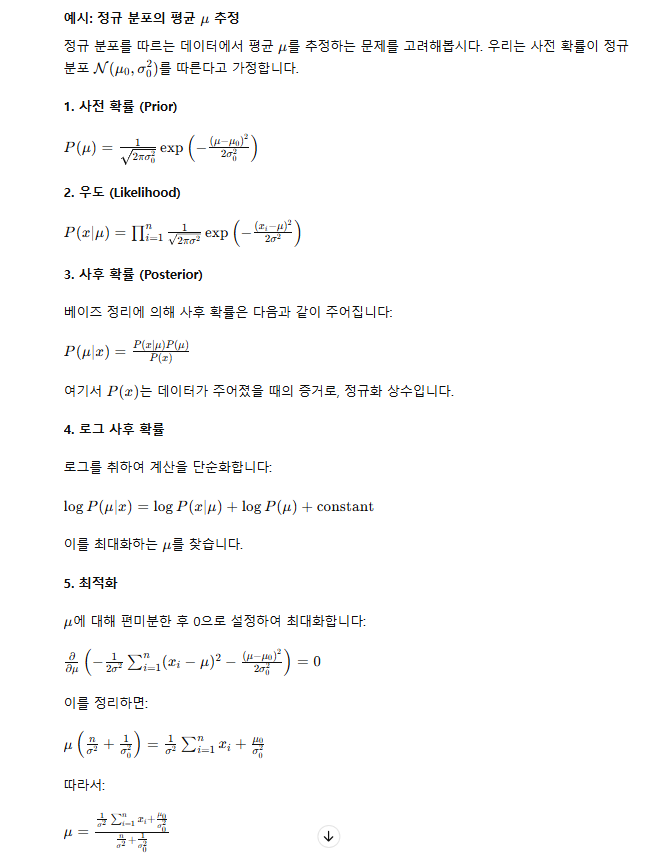

**사전 확률을 선택하는 방법**

- 사전 확률은 다양한 방식으로 선택할 수 있으며, 모델의 성능에 큰 영향을 미침
- 사전 확률은 MAP 추정에 중요한 영향을 미치며, 파라미터의 분포 지식을 반영
- 객관적인 정보, 주관적인 지식, 실증적인 데이터 등을 활용하여 적절한 사전 확률을 설정하는 것이 중요
- 여러 사전 확률을 시험해 보고 가장 성능이 좋은 것을 선택하는 것이 일반적인 방법

주요 유형
- 객관적인 사전 확률(Objective prior):</br>
특징: 데이터에 사전 확률의 영향을 최소화</br>
예시: 모든 가능성을 균등하게 고려하는 균등 분포, 정보가 없을 때 사용.
- 주관적인 사전 확률(Subjective prior):</br>
특징: 모델 외부의 주관적 정보를 반영하여 설정</br>
예시: 전문가의 지식을 반영하여 특정 값에 더 높은 확률을 부여.
- 실증적 사전 확률(Empirical prior):</br>
특징: 이전의 데이터나 경험을 바탕으로 설정됩니다.
예시: 과거 데이터를 분석하여 얻은 통계적 정보를 기반으로 설정.</br>
- 사전 확률의 조합 혼합 방법:
여러 사전 확률을 혼합하여 사용. 예를 들어, 주관적인 지식과 객관적인 정보를 결합하여 더 균형 잡힌 사전 확률을 설정

여러 사전 확률을 적용해 보고 모델의 성능을 평가하여 가장 적합한 사전 확률을 선택

동전 던지기 예시:

- 객관적인 사전 확률: 동전이 공정할 것이라는 가정하에 앞면과 뒷면의 확률을 0.5로 설정.
- 주관적인 사전 확률: 이전 경험에 의해 이 동전이 약간 앞면이 더 많이 나올 것이라고 생각해서 앞면의 확률을 0.6으로 설정.
- 실증적 사전 확률: 과거의 동전 던지기 데이터를 바탕으로 앞면이 나올 확률을 0.55로 설정.

의학 연구 예시:
- 객관적인 사전 확률: 새로운 약물이 효과가 있을지 모른다는 가정하에 효과와 무효의 확률을 균등하게 설정.
- 주관적인 사전 확률: 기존 연구와 전문가의 의견을 반영하여 약물이 효과가 있을 확률을 높게 설정.
- 실증적 사전 확률: 이전 임상 시험 데이터를 바탕으로 약물의 효과 확률을 설정.

#### **추론을 단순하게 유지하는 방법: 켤레 사전 확률**

사전 확률 분포와 사후 확률 분포가 같은 유형의 분포가 되도록 하는 사전 확률</BR>
수학적 계산을 단순화하고 효율적으로 수행할 수 있게 하는 것

켤레 사전 확률을 사용하면 사후 확률 분포가 사전 확률 분포와 동일한 유형의 분포일 가능성이 높아져 추론 과정을 단순하게 할 수 있음

장점
- 계산의 단순화: 사후 확률을 계산할 때 복잡한 수치적 방법을 사용할 필요 없이 폐쇄형 해(closed-form solution)를 얻을 수 있습니다.
- 업데이트 용이: 사후 확률을 다음 업데이트의 사전 확률로 사용할 수 있습니다.

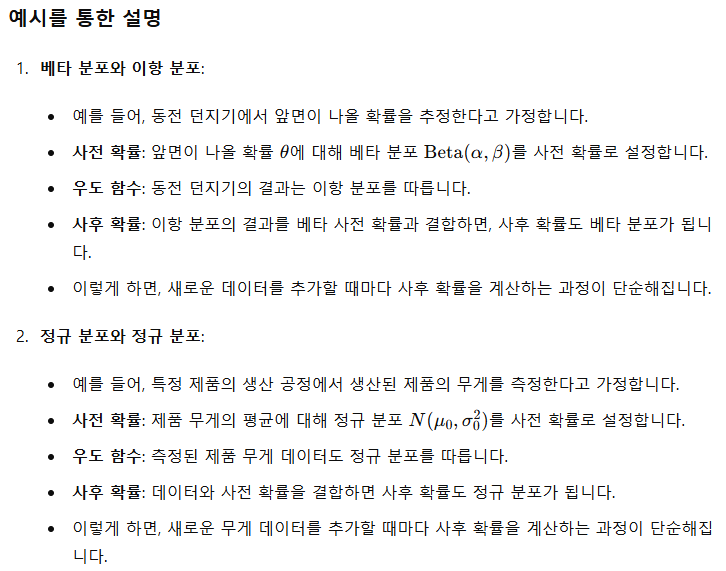

사전 확률과 사후 확률이 같은 유형의 분포를 가지게 되어, 추론 과정을 단순화하고 계산을 쉽게 할 수 있음. 이를 통해 모델 업데이트와 추론 과정이 더욱 효율적이고 직관적으로 이루어짐.

##### 이진 분류 문제로 켤레 사전 확률 프로세스 확인</br>
자산 가격 변동의 동적 확률 추정

베르누이 분포와 베타 분포를 이용한 켤레 사전 확률 모델링

1. 베르누이 분포:</br>
데이터가 성공(1) 또는 실패(0)와 같은 두 가지 결과로만 이루어질 때 사용.</br>
예시: 주식 시장에서 특정 조건을 만족하면 성공으로 간주하는 경우.

2. 베타 분포:</br>
베르누이 분포의 성공 확률에 대한 사전 확률로 사용</br>
사전 지식이나 데이터를 반영하여 확률을 모델링할 때 유용</br>

※ 사전 확률과 사후 확률:

베타 분포를 사전 확률로 사용하면, 새로운 데이터가 들어올 때마다 쉽게 업데이트 가능</br>
사전 확률을 통해 초기 가정을 설정하고, 이후 데이터에 따라 사후 확률을 갱신

S&P 500 수익률 예시:
주어진 데이터 샘플에서 수익률이 양(+)인 경우의 성공 확률을 베르누이 분포로 모델링.
초기 사전 확률을 베타 분포로 설정한 후, 데이터를 통해 사후 확률을 업데이트.
사전 확률이 베타 분포이기 때문에, 사후 확률도 베타 분포로 유지되며 업데이트가 용이.

잠깐...</br>
S&P500 데이터를 사용하는 것 대신
동전 던지기로 대리 실습

→ 결과는 동일하다!!!

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
import warnings

In [ ]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' # []리스트 받아들일수 없기 때문...

In [ ]:
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_style('dark')

In [ ]:
# 각 서브플롯을 형식화하는 사용자 정의 함수
def format_plot(axes, i, p, y, trials, success, true_p, tmle, tmap=None):
    fmt = FuncFormatter(lambda x, _: f'{x:.0%}')
    if i >= 6:
        axes[i].set_xlabel("$p$, Success Probability")
        axes[i].xaxis.set_major_formatter(fmt)
    else:
        axes[i].axes.get_xaxis().set_visible(False)
    if i % 3 == 0:
        axes[i].set_ylabel("Posterior Probability")
    axes[i].set_yticks([], [])

    axes[i].plot(p, y, lw=1, c='k')
    axes[i].fill_between(p, y, color='darkblue', alpha=0.4)
    axes[i].vlines(true_p, 0, max(10, np.max(y)), color='k', linestyle='--', lw=1)
    axes[i].set_title(f'Trials: {trials:,d} - Success: {success:,d}')
    if i > 0:
        smle = r"$\theta_{{\mathrm{{MLE}}}}$ = {:.2%}".format(tmle)
        axes[i].text(x=.02, y=.85, s=smle, transform=axes[i].transAxes)
        smap = r"$\theta_{{\mathrm{{MAP}}}}$ = {:.2%}".format(tmap)
        axes[i].text(x=.02, y=.75, s=smap, transform=axes[i].transAxes)
    return axes[i]

In [ ]:
import pandas as pd

In [ ]:
!sudo apt-get update
!sudo apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [872 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,083 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/u

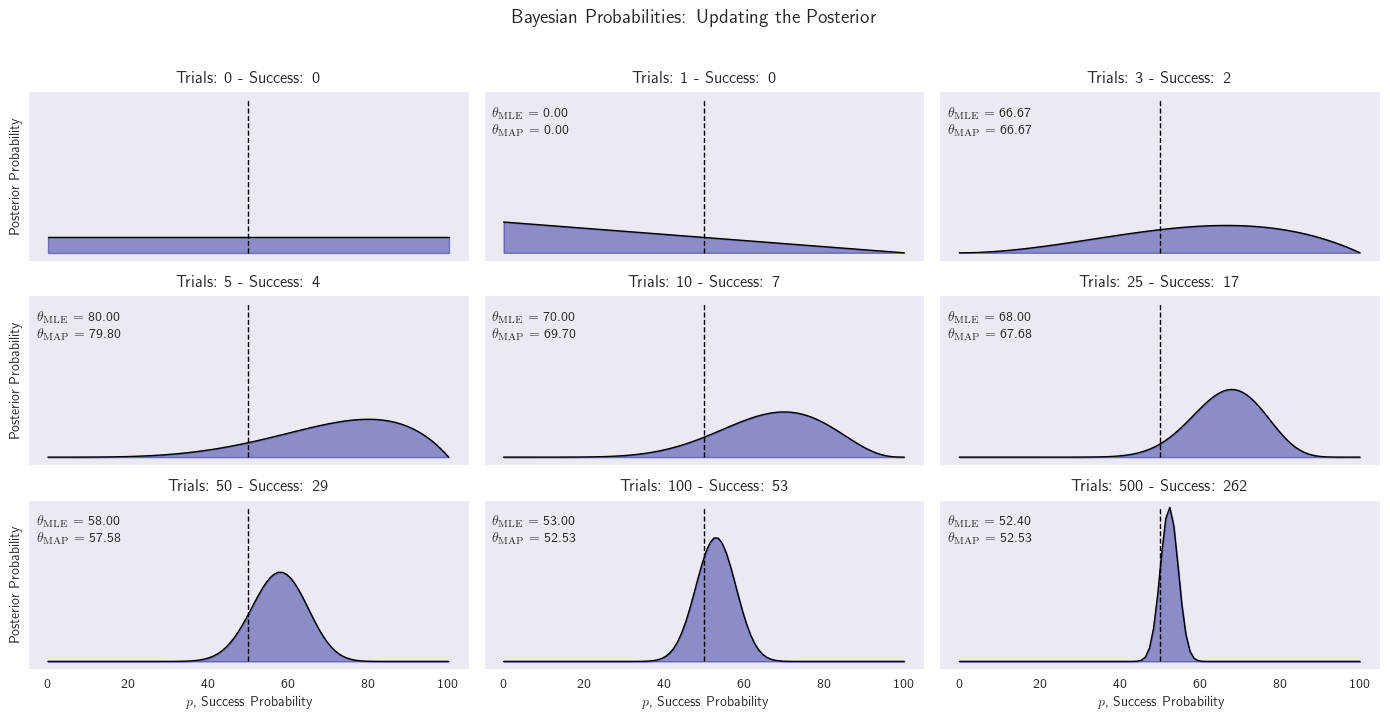

In [ ]:
n_trials = [0, 1, 3, 5, 10, 25, 50, 100, 500]
# 베르누이 분포는 단일 시행에서 성공 또는 실패의 두 가지 결과만 가능한 확률 분포
outcomes = stats.bernoulli.rvs(p=0.5, size=n_trials[-1])
p = np.linspace(0, 1, 100)
# uniform (uninformative) prior
a = b = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 7), sharex=True)
axes = axes.flatten()
fmt = FuncFormatter(lambda x, _: f'{x:.0%}')

# 각 실험에서 얻은 성공 횟수를 기반으로 사후 분포를 업데이트.
for i, trials in enumerate(n_trials):
    successes = outcomes[:trials]
    theta_mle = np.mean(successes)  #theta_mle: 최대 우도 추정(MLE)로 성공 확률의 평균.
    heads = sum(successes)          # heads와 tails를 통해 성공과 실패 횟수를 계산.
    tails = trials - heads
    update = stats.beta.pdf(p, a + heads , b + tails) # update: 베타 분포의 확률 밀도 함수를 사용하여 사후 분포를 계산.
    theta_map = pd.Series(update, index=p).idxmax() # theta_map: 최대 사후 확률(MAP) 추정.
    axes[i] = format_plot(axes, i, p, update, trials=trials, success=heads,
                          true_p=.5, tmle=theta_mle, tmap=theta_map)

title = 'Bayesian Probabilities: Updating the Posterior'
fig.suptitle(title,  y=1.02, fontsize=14)
fig.tight_layout()

베이즈 추론을 통해 동적으로 사후 확률 분포를 업데이트하는 과정을 효과적으로 시각화

MAP 추정치는 균일 사전 확률 분포의 기대값 쪽으로 당겨지는 경향

In [ ]:
n_days = [0, 1, 3, 5, 10, 25, 50, 100, 500]
# random sample of trading days
# outcomes = sp500_binary.sample(n_days[-1])

# initial 500 trading days
# binarized daily S&P 500
outcomes = sp500_binary.iloc[:n_days[-1]]
p = np.linspace(0, 1, 100)

# uniform (uninformative) prior
a = b = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 7), sharex=True)
axes = axes.flatten()
for i, days in enumerate(n_days):
    successes = outcomes.iloc[:days]
    theta_mle = successes.mean()
    up = successes.sum()
    down = days - up
    update = stats.beta.pdf(p, a + up , b + down)
    theta_map = pd.Series(update, index=p).idxmax()
    axes[i] = format_plot(axes, i, p, update, trials=days, success=up,
                          true_p=sp500_binary.mean(), tmle=theta_mle, tmap=theta_map)

title = 'Bayesian Probabilities: Updating the Posterior'
fig.suptitle(title,  y=1.02, fontsize=14)
fig.tight_layout()

##### 정리
켤레 사전 확률:

개념: 켤레 사전 확률은 특정한 사전 분포를 사용하면, 사후 분포가 동일한 유형의 분포로 유지</br> 베르누이 분포와 베타 분포의 조합이 이에 해당</br>
장점: 계산이 단순화되며, 새로운 데이터가 추가될 때 사후 분포를 쉽게 갱신가능하여 계산 효율성을 높이는 데 도움</br>
단점: 실제 데이터와 항상 일치하지 않을 수 있으며, 현실의 복잡한 상황을 충분히 반영하지 못할 수 있음</br>
단순화된 MAP 접근:
개념: 최대 사후 확률을 추정하는 방법으로, 사전 확률과 우도 함수를 결합하여 파라미터를 추정</br>
장점: 계산이 간단하여 빠르게 결과를 얻을 수 있음</br>
단점: 증거 항목을 정확히 계산하지 않아서, 추정치가 덜 정확할 수 있음</br>


이러한 단점을 극복하기 위해...

###10.1.3 결정론적 근사 및 확률론적 근사 추론

 복잡한 모델의 경우, 사후 확률 분포를 정확하게 계산하는 것이 어려울 수 있기 때문에 근사 방법을 사용

개념: 모델의 파라미터가 너무 많거나 복잡해서 사후 확률 분포를 공식적으로 계산할 수 없는 경우, 근사 방법을 사용하여 해결</br>
연속형 변수: 연속형 변수의 경우, 적분을 통해 사후 확률을 계산할 수 없을 </br>
복잡한 모델: 모델이 복잡할수록 사후 확률을 계산하기 어려워지므로 근사 방법이 필요</br>

예시: 아주 어려운 수학 문제를 풀 때, 정확한 답을 구하기보다는 대략적인 답을 구하는 것처럼, 복잡한 모델의 사후 확률 분포도 근사적으로 계산


 베이즈 추론에서 사용되며, 복잡한 사후 확률 분포를 추정하는 데 도움

#### MCMC (Markov Chain Monte Carlo) 방법:

매우 복잡한 문제를 해결하기 위해 여러 번 시도해 보고 그 결과를 평균내어 정확한 답을 찾는 방법
예시: 어려운 퍼즐을 풀기 위해 여러 번 시도한 후 가장 자주 나타나는 답을 선택하는 것과 같습니다.
장점: 매우 정확한 결과를 제공하지만, 계산이 오래 걸릴 수 있습니다.


변분 추론 (Variational Inference):

이해하기 쉽게: 복잡한 문제를 단순화하여 빠르게 해결하는 방법입니다.
예시: 퍼즐의 일부를 간단하게 만들어 빠르게 풀 수 있도록 하는 것과 같습니다.
장점: 계산이 빠르고 대규모 문제에도 적용할 수 있습니다. 그러나 완벽히 정확하지 않을 수 있습니다.

**마르코프 체인 몬테카를로 표본 추출**

표본 추출은 주어진 분포에서 데이터를 추출하는 과정

주요 포인트
독립성 가정: 표본이 독립적이라 가정할 때, 많은 표본을 통해 통계량을 추정할 수 있습니다.
편향되지 않은 추정량 (Unbiased Estimator):
 표본 평균 같은 통계량이 실제 분포의 평균과 동일한 경우. 편향되지 않은 추정량은 정확한 추정을 위해 중요. 표본의 수가 많을수록 추정이 더 정확
 표본을 많이 추출하는 것은 계산 비용이 증가

ㅇ)
박스 안에 있는 공의 평균 숫자를 알고 싶습니다.
해결: 몇 개의 공을 뽑아 평균을 계산합니다. 이때 뽑은 공들의 평균이 박스 안 모든 공의 평균과 같다면 편향되지 않은 추정량입니다.
 공을 많이 뽑을수록 평균이 정확해지지만, 시간이 많이 걸립니다.
해결: MCMC와 같은 효율적인 방법을 사용하여 적은 수의 공으로도 정확한 평균을 추정합니다.

**마르코프 체인(Markov Chain)**:</br>
: 동적 확률 모델로, 현재 상태가 다음 상태에만 영향을 주며, 과거 상태와는 독립적

마르코프 성질

image.png

미래 상태는 현재 상태에 의해서만 결정

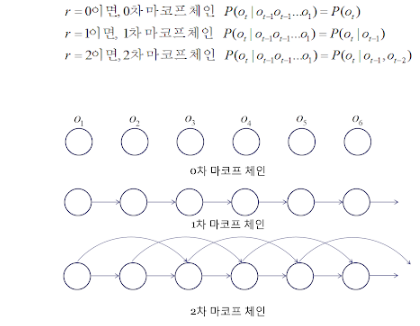

예시:
1. 날씨 예측에서 오늘 날씨가 내일 날씨를 결정하지만, 어제의 날씨는 상관없음.
→오늘이 비오는 날이면 내일도 비가 올 확률이 높다.

2. 현재 주식 시장의 상태만을 고려하여 미래의 상태를 예측.

**몬테카를로 방법(Monte Carlo methods)**:</br>
반복적인 무작위 표본 추출을 통해 문제를 해결하는 방법</br>
정확한 해를 찾기 위해 결정론적 방법 대신 확률론적 접근을 사용


예시:
1. 동전을 100번 던져서 앞면이 나올 확률을 구하려고 할 때, 여러 번 던져서 그 결과를 평균내는 것과 같음
2. 원주율(π)을 구하기 위해 원 안에 무작위로 점을 찍고, 점이 원 안에 들어가는 비율을 계산하는 방법

몬테카를로 방법의 예시
예시 1: 원주율(π) 추정
문제 정의:

단위 정사각형 내에 단위 원이 내접해 있습니다. 원주율(π)을 추정하고자 합니다.
샘플링 전략:

정사각형 내에 무작위로 점을 생성합니다.
원 안에 들어가는 점의 비율을 계산합니다.
무작위 샘플 생성:

정사각형 내의 좌표 (x, y)를 무작위로 생성합니다.
점이 원 안에 들어가는지 검사합니다.
평균 계산:

원 안에 들어간 점의 수를 전체 점의 수로 나누어 비율을 계산합니다.
이 비율을 4배하여 원주율(π)을 추정합니다.

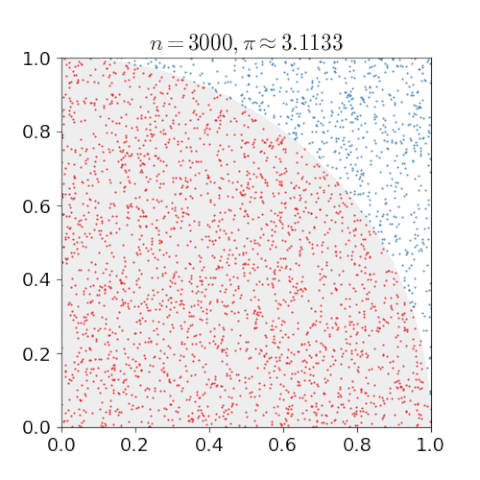

 MCMC는 복잡한 확률 분포에서 샘플을 추출하기 위해 사용되는 방법

MCMC 절차:

1. 현재 위치에서 시작.
2. 제안된 분포에서 새로운 위치를 선택.
3. 새로운 위치에서의 확률을 평가.
새로운 위치를 채택하거나 유지.
4. 과정을 반복하여 모든 포지션을 반영.

- 유의 사항:</br>
① 초기 샘플 버리기: 초기 몇 번의 샘플은 신뢰할 수 없으므로 버립니다.(burn-in sample).</br>
② 메모리리스 프로퍼티: 현재 위치만 중요하며, 과거 위치는 중요하지 않습니다.(memoryless property)</br>
③ 수렴 검증: 프로세스가 제대로 수렴하는지 확인하기 위해 여러 가지 검증을 수행

- 예시</br>
① 초기 샘플 버리기: 주식 가격 예측을 처음 몇 번 할 때는 모델이 안정되지 않으므로 이 데이터를 버립니다.</br>
② 메모리리스 프로퍼티: 현재 주식 가격만 고려하며, 이전 가격들은 고려하지 않습니다.</br>
③ 수렴 검증: 모델이 주식 가격을 예측할 때 일관되게 수렴하는지 확인합니다.

**마르코프 체인 몬테카를로(MCMC) 방법**

1. 깁스 표본 추출</br>
다차원 확률 분포에서 샘플을 추출하는 기법</br> 특히, 조건부 분포를 이용하여 각 변수의 값을 순차적으로 샘플링함으로써 다변량 분포로부터 표본을 얻는 방법

2. 메트로폴리스-헤이스팅스 표본 추출

3. 해밀턴 몬테카를로(Hamiltonian Monte Carlo, HMC) 방법과 No-U-Turn 샘플러(NUTS)

#### 변분 추론과 자동 미분

변분 추론(Variational Inference, VI):

개념: 복잡한 확률 분포를 근사화하기 위해 최적화 기법을 사용하는 방법입니다.
절차:
확률 분포의 모수 집합을 선택하고
쿨백-라이블러 발산(Kullback-Leibler divergence)을 최소화하여 목표 분포에 가장 가까운 근사 분포를 찾는 방법
장점: 빠르게 수렴하고 대규모 데이터셋에서도 효율적으로 작동</br>
쉽게 말해서...</br>
여러 가지 근사치를 계산한 후, 실제 답에 가장 가까운 근사치를 선택


자동 미분(Automatic Differentiation):

개념: 머신러닝 모델의 기울기 계산을 자동화하여, 최적화 과정의 효율성을 높이는 기술

## 10.2 PyMC3를 사용한 확률 프로그래밍

- PyMC3: 복잡한 확률 모델을 설계, inference, 진단 및 평가하는 데 사용되는 파이썬 기반 라이브러리</br>  베이지안 추론의 개념을 쉽게 적용할 수 있도록 도와주며, 특히 머신러닝과 데이터 분석에 유용

- PyMC3의 장점:
사용 용이성, MCMC와 변분 추론 등의 고급 추론 기법을 지원
- 역사적 배경: 2012년 처음 개발되어 지속적으로 발전

### 10.2.1 테아노를 이용한 베이지안 머신러닝

- 테아노(Theano):
Theano는 PyMC3의 백엔드로 사용되며, 복잡한 계산을 자동으로 처리하고 최적화하는 도구</br>
MILA(Montreal Institute for Leaning Algorithm)에서 개발되었으며, GPU 지원을 통해 빠른 계산을 가능
- PyMC3는 Theano와 결합하여 베이지안 머신러닝에서 강력한 성능을 발휘하며, 복잡한 수학적 계산을 효율적으로 처리

### 10.2.2 PyMC3 워크플로: 경기 침체 예측

모델링 프로세스

1. 단계를 정의하여 확률 모델을 인코딩:</br>
- 사전 확률 분포 설정: 잠재 변수에 대한 사전 확률을 설정.
- 관측된 데이터: 관련된 데이터를 사용하여 파라미터를 조정.
2. 사후 확률 추론:
- MAP 추정: 최대 사후 확률 추정.
- MCMC: 마르코프 체인 몬테카를로 방법.
- 변분 베이즈 방법: 근사적인 사후 확률 추론
3. 모델 검증:
- 다양한 진단 도구를 사용하여 모델을 검증.
4. 예측 생성:
- 검증된 모델을 사용하여 예측 생성

**데이터: 주요 경기 침체 지표**

경기 침체 예측에 사용되는 주요 경제 지표와 데이터를 소개</br>
간단한 데이터 세트를 활용하여 경기 침체를 예측하는 워크플로우를 수행하며, 미국 경기 침체를 분석하는 데 사용되는 다양한 지표들을 소개

데이터 소스

- NBER: National Bureau of Economic </br>
경기 침체 날짜 정의
- FRED: Federal Reserve's Economic Data</br>
경기 침체 시작 예측을 위한 4가지 변수


주요 경기 침체 지표:
- 미국 국채 수익률 곡선의 장기 스프레드: 10년 국채 수익률과 3개월 국채 수익률 간의 차이.
- 미시건 대학교 소비자 심리 지수: 소비자 신뢰를 측정하는 지수.
- 시카고 연준 금융 상태 지수: 금융시장의 상황을 나타내는 지수.
- NFCI 비금융 레버리지 서브인덱스: 금융상황의 변동성을 나타내는 지수

데이터 세트 설명:
- 1982년에서 2019년까지의 약 457개월간의 관측치를 사용. 분기가 경기 침체로 분류되면 그 분기 모든 달을 경기 침체로 간주
월간 빈도로 모든 지표를 월 단위로 변환하여 분석.
경기 침체 예측:

모델:
- 미국 경제는 앞으로 몇 개월 후 경기 침체에 빠지는가?(48개월을 경기 침체로 제한)

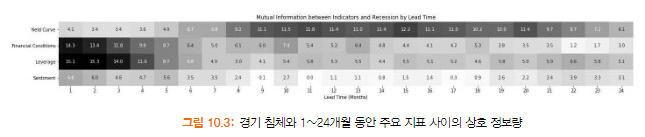

- 주요 지표</br>
Yield Curve (수익률 곡선), Financial Conditions (금융 상태), Leverage (레버리지), Sentiment (소비자 심리), Lead Time (선행 시간)

- 1개월부터 24개월까지의 시간 동안 경기 침체와 각 지표 간의 상호 정보량을 표시

- 상호 정보량 해석</br>
값이 클수록 해당 지표와 경기 침체 간의 상관성이 높음을 나타냄</br>
예를 들어, "Financial Conditions"의 경우, 여러 개월 동안 다른 지표보다 높은 상호 정보량 값을 가지므로, 금융 상태 지표가 경기 침체를 예측하는 데 더 중요한 역할을 한다는 것을 의미

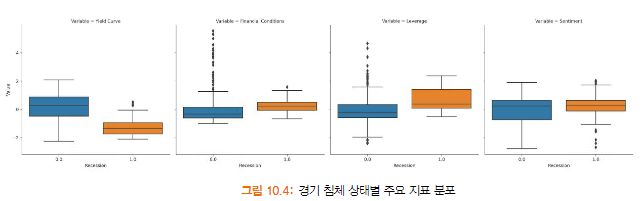

변수(Variables):

- Yield Curve (수익률 곡선): 경기 침체 여부에 따른 수익률 곡선의 분포.
- Financial Conditions (금융 상태): 경기 침체 여부에 따른 금융 상태 지수의 분포.
- Leverage (레버리지): 경기 침체 여부에 따른 레버리지 지수의 분포.
- Sentiment (소비자 심리): 경기 침체 여부에 따른 소비자 심리 지수의 분포.
- Recession (경기 침체 여부):0.0 경기 침체가 없는 기간, 1.0: 경기 침체가 있는 기간

**모델 정의: 베이지안 로지스틱 회귀**

로지스틱 회귀 분석은 특성 집합과 이진 결과 사이의 선형 관계 추정, 시그모이드 함수로 확률 생성

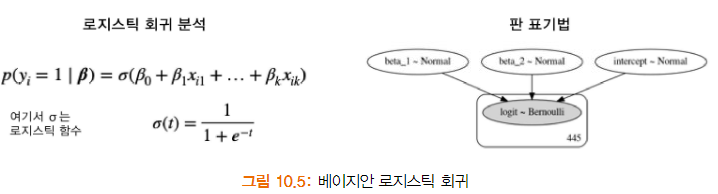

판 표기법(Plate Notation)은 그래픽 모델을 시각적으로 표현하는 방법 중 하나로, 특히 베이지안 네트워크와 같은 확률적 그래픽 모델에서 사용됩

In [ ]:
!pip install theano

In [ ]:
!pip install --upgrade numpy
!pip install theano pymc3

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.1
    Uninstalling numpy-1.22.1:
      Successfully uninstalled numpy-1.22.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.26 requires scipy>=1.9, but you have scipy 1.7.3 which is incompatible.
jaxlib 0.4.26+cuda12.cudnn89 requires scipy>=1.9, but you have scipy 1.7.3 which is incompatible.
pymc 5.10.4 requires arviz>=0.13.0, but you have arviz 0.12.1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.26.4 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.4 which is incompatible.
statsmodels 0.14.2 requires scipy!=1.9.2,>=1.8, but you have scipy 1.7.3 which is incompatible.
  Using cached numpy-1.22.1-cp3

In [ ]:
%matplotlib inline
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

AttributeError: module 'numpy.distutils.__config__' has no attribute 'blas_opt_info'

In [ ]:
import pymc as pm

In [ ]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + beta_1 *
                             data.hours + beta_2 * data.educ)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=data.income)

NameError: name 'pm' is not defined

단계
1. 데이터(주요 경기 침체 지표) 가져오기
2. 모델 정의: 베이지안 로지스틱 회귀
3. 추론 - MAP 추론,근사 추론(MCMC), 근사 추론(변분 베이즈)
4. 모델 진단
5. 예측 생성

## 10.3 트레이딩을 위한 베이지안 머신러닝

- 샤프 비율(Sharpe Ratio)을 통한 성과 비교:
더 통찰력 있는 성과 비교를 위해 샤프 비율을 확률 모델로 모델링.
- 베이지안 선형 회귀 분석을 사용한 페어 트레이딩 헤지 비율 계산:
베이지안 선형 회귀 분석을 통해 페어 트레이딩 전략에서 헤지 비율을 계산.
- 베이지안 관점에서 선형 시계열 모델 분석:
베이지안 접근법을 사용하여 선형 시계열 모델을 분석.

### 10.3.1 성과 비교를 위한 베이지안 샤프 비율

샤프 비율(Sharpe Ratio)이란?</br>
- 샤프 비율은 투자 성과를 평가하는 데 사용되는 지표로, 투자 수익률의 초과 수익(무위험 수익률을 초과하는 부분)을 단위 변동성(표준 편차) 당 얼마만큼 얻었는지를 나타냄. </br>
- 특정 투자나 포트폴리오의 위험 조정 수익률을 평가하는 데 유용

사용자 지정 확률 모델 정의

이 절에서는 샤프 비율(Sharpe Ratio)을 확률 모델로 정의하고, 이를 통해 수익률의 분포와 관련된 정보를 모델링하는 방법을 다룸

- 샤프 비율의 확률 모델 정의:
샤프 비율을 모델링하려면 수익률의 분포와 관련된 사전 확률 정보를 알아야 합니다.
여기서 스튜던트 t 분포는 낮은 자유도(degree of freedom)를 가질 때 꼬리가 두껍게 나타나는 분포로, 수익률의 분포를 모델링하는 데 적합합니다.

- 모델의 파라미터:
-- 평균 (mean): 수익률의 평균.
-- 표준 편차 (standard deviation): 수익률의 변동성.
-- 자유도 (degrees of freedom): 스튜던트 t 분포의 자유도.

- 모델링 과정:
각각의 평균, 표준 편차, 자유도에 대한 정규 분포와 균일 분포, 지수 분포를 가정합니다.
이를 통해 수익률의 평균, 표준 편차 및 자유도를 모델링합니다.

In [ ]:
# MKL 설치
!pip install mkl
!pip install mkl-service

# numpy 최신 버전으로 업그레이드
!pip install --upgrade numpy

# Theano와 PyMC3 설치
!pip install theano pymc3

# Theano 환경 설정
import os
os.environ['THEANO_FLAGS'] = 'blas__check_openmp=False,floatX=float32,device=cuda'

# 필요한 라이브러리 불러오기
import numpy as np
import theano
import theano.tensor as T
import pymc3 as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.6 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.1
    Uninstalling numpy-1.22.1:
      Successfully uninstalled numpy-1.22.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.26 requires scipy>=1.9, but you have scipy 1.7.3 which is incompatible.
jaxlib 0.4.26+cuda12.cudnn89 requires scipy>=1.9, but you have scipy 1.7.3 which is incompatible.
pymc 5.10.4 requires arviz>=0.13.0, but you have arviz 0.12.1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.26.4 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.4 which is incompatible.
statsmodels 0.14.2 requires scipy!=1.9.2,>=1.8,

AttributeError: partially initialized module 'theano' has no attribute 'graph' (most likely due to a circular import)

In [ ]:
import pymc3 as pm
import numpy as np

# 데이터의 평균과 표준 편차 계산
mean_prior = data.stock.mean()
std_prior = data.stock.std()
std_low = std_prior / 1000
std_high = std_prior * 1000

# PyMC3를 사용한 샤프 비율 모델 정의
with pm.Model() as sharpe_model:
    mean = pm.Normal('mean', mu=mean_prior, sd=std_prior)
    std = pm.Uniform('std', lower=std_low, upper=std_high)
    nu_minus_two = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2
    returns = pm.StudentT('returns', nu=nu_minus_two, mu=mean, sd=std, observed=data.stock)

    # 샤프 비율 계산
    sharpe = returns.distribution.mean / returns.distribution.variance ** 0.5 * np.sqrt(252)
    pm.Deterministic('sharpe', sharpe)

RuntimeError: 
Could not import 'mkl'.  If you are using conda, update the numpy
packages to the latest build otherwise, set MKL_THREADING_LAYER=GNU in
your environment for MKL 2018.

If you have MKL 2017 install and are not in a conda environment you
can set the Theano flag blas__check_openmp to False.  Be warned that if
you set this flag and don't set the appropriate environment or make
sure you have the right version you *will* get wrong results.


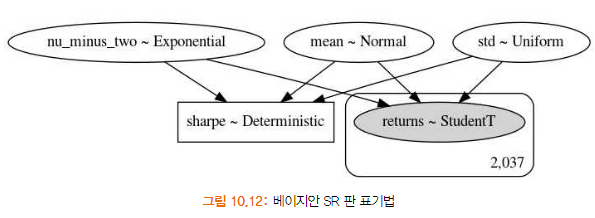

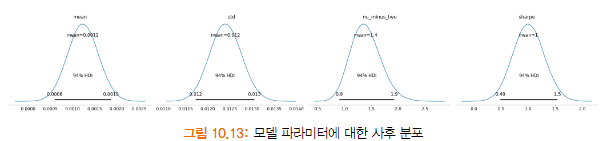

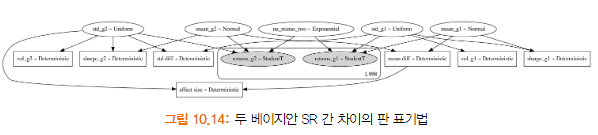

--------------------------------------------------------------------------